In [35]:
from pyspark.sql import SparkSession
import numpy as np
spark = SparkSession.builder.master("local[*]").appName("predict_insurance_costs").getOrCreate()


data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/home/dangkhacloc/Downloads/insurance.csv")


data.cache()
# so dong du lieu
data.count()

1338

In [36]:
display(data)

data.printSchema()

DataFrame[age: int, sex: string, bmi: double, children: int, smoker: string, region: string, charges: double]

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [37]:
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [38]:
# Mo ta ve tap du lieu
data.describe().show()
data.createOrReplaceTempView("insurance")
spark.sql("SELECT count(region), region FROM insurance group by region order by region").show(100)

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+

+-------------+---

In [39]:
data.createOrReplaceTempView("insurance")
# Chuyen doi cac thuoc tinh dang string sang numberic
from pyspark.ml.feature import StringIndexer
# I. With SEX
# Create StringIndexer
sex_indexer = StringIndexer(inputCol = "sex", \
                             outputCol = "sex_index")


# II. With SMOKER
# Create StringIndexer
smoker_indexer = StringIndexer(inputCol = "smoker", \
                             outputCol = "smoker_index")

# III. With REGION
# Create StringIndexer
region_indexer = StringIndexer(inputCol = "region", \
                            outputCol = "region_index")


In [40]:
# Make a VectorAssembler de gom cac thuoc tinh de du doan vao mot features
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = ["age", "sex_index", "bmi", \
                                             "children", "smoker_index",\
                                             "region_index"], 
                                outputCol = "features")

In [41]:
#Chuyen doi du lieu model thong qua pipeline
from pyspark.ml import Pipeline

# Make a pipeline
flights_sea_pipe  = Pipeline(stages = [sex_indexer, smoker_indexer, \
                                       region_indexer,vec_assembler])

In [42]:
# create pipe_data from pipeline
pipe_data = flights_sea_pipe.fit(data).transform(data)


In [43]:
pipe_data.select("features").show()

+--------------------+
|            features|
+--------------------+
|[19.0,1.0,27.9,0....|
|[18.0,0.0,33.77,1...|
|[28.0,0.0,33.0,3....|
|[33.0,0.0,22.705,...|
|[32.0,0.0,28.88,0...|
|[31.0,1.0,25.74,0...|
|[46.0,1.0,33.44,1...|
|[37.0,1.0,27.74,3...|
|[37.0,0.0,29.83,2...|
|[60.0,1.0,25.84,0...|
|[25.0,0.0,26.22,0...|
|[62.0,1.0,26.29,0...|
|[23.0,0.0,34.4,0....|
|[56.0,1.0,39.82,0...|
|[27.0,0.0,42.13,0...|
|[19.0,0.0,24.6,1....|
|[52.0,1.0,30.78,1...|
|[23.0,0.0,23.845,...|
|[56.0,0.0,40.3,0....|
|[30.0,0.0,35.3,0....|
+--------------------+
only showing top 20 rows



In [44]:
pipe_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- smoker_index: double (nullable = false)
 |-- region_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [45]:
# Tao tap du lieu train va test
data_train, data_test = pipe_data.randomSplit([0.8, 0.2],1000)
data_train.show(5)
data_test.show(5)

+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|   charges|sex_index|smoker_index|region_index|            features|
+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
| 18|female| 20.79|       0|    no|southeast| 1607.5101|      1.0|         0.0|         0.0|[18.0,1.0,20.79,0...|
| 18|female| 21.66|       0|   yes|northeast|14283.4594|      1.0|         1.0|         3.0|[18.0,1.0,21.66,0...|
| 18|female| 24.09|       1|    no|southeast| 2201.0971|      1.0|         0.0|         0.0|[18.0,1.0,24.09,1...|
| 18|female|26.315|       0|    no|northeast|2198.18985|      1.0|         0.0|         3.0|[18.0,1.0,26.315,...|
| 18|female| 26.73|       0|    no|southeast| 1615.7667|      1.0|         0.0|         0.0|[18.0,1.0,26.73,0...|
+---+------+------+--------+------+---------+----------+---------+------------+---------

# Train_LR_FULL_FEATURES


In [46]:
train  = data_train.select("age", "sex_index", "bmi","children", "smoker_index","region_index","charges")

test  = data_test.select("age", "sex_index", "bmi","children", "smoker_index","region_index","charges")




In [47]:
rdd_train=train.rdd
rdd_test=test.rdd


In [48]:
weight = []
lr_delta=[]
loss=sc.parallelize([])

In [49]:
lr = 0.0001
NumberUpdateW=100
np.random.seed(100)
number_of_rdd_train=rdd_train.count()
def create_weight():
    global weight
    global lr_delta
    one_instance=np.array(rdd_train.first())
    yi=one_instance[-1]
    xi=one_instance[:-1]
    weight = np.zeros([len(xi)+1, 1])
    lr_delta=np.zeros([len(xi)+1, 1])
    #print(weight)

In [50]:
print(number_of_rdd_train)

1070


In [51]:
create_weight()
print(weight)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [52]:
def fit_tinh_motcot_delta(x,weight,lancapnhat_thu):
    #lan cap nhat da cong 1 de tranh truong hop lan cap nhat thu 0
    x=np.array(x)
    yi=x[-1]
    xi=x[:-1]
    features=len(xi)
    
    xi=np.append(xi,1)
    
    yi=yi.reshape([-1,1])
    
    loss_chua2= np.array( np.dot(xi, weight)-yi )
    newarray=[]
    newarray.append((-lancapnhat_thu,loss_chua2**2))
    
    for i in range(features+1):
        newarray.append((i,xi[i]*loss_chua2))
    
    
   
    return newarray

In [53]:

import time
def train_weight():
    global weight
    global lr_delta
    global lr
    global loss
    cot_delta=rdd_train.flatMap(lambda x: fit_tinh_motcot_delta(x,weight,1))

    delta_loss_1=cot_delta.reduceByKey(lambda a,b:a+b)

    delta_loss_2=delta_loss_1.map(lambda x:(x[0],x[1]/number_of_rdd_train))

    delta=delta_loss_2.filter(lambda x:x[0]>=0)

    for ite in delta.collect():
        lr_delta[ite[0]]=ite[1]*lr

    weight=weight-lr_delta

    loss=delta_loss_2.filter(lambda x:x[0]<0)

    #print(delta_loss_2.collect())
    for i in range(1,NumberUpdateW):
        cot_delta=rdd_train.flatMap(lambda x: fit_tinh_motcot_delta(x,weight,i+1))

        delta_loss_1=cot_delta.reduceByKey(lambda a,b:a+b)

        delta_loss_2=delta_loss_1.map(lambda x:(x[0],x[1]/number_of_rdd_train))

        delta=delta_loss_2.filter(lambda x:x[0]>=0)

        for ite in delta.collect():
            lr_delta[ite[0]]=ite[1]*lr

        weight=weight-lr_delta

        loss=loss.union(delta_loss_2.filter(lambda x:x[0]<0))

        #print(delta_loss_2.collect())
        #print(weight)
   

In [54]:

start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)

Time taken in seconds: 41.482807874679565


In [55]:
print(weight)

[[216.08453131]
 [ -3.08604773]
 [168.36997063]
 [ 11.58040541]
 [ 40.02821651]
 [  0.74857772]
 [  2.98483671]]


In [56]:
def predict(x,weight):
    x=np.array(x)
    yi=x[-1]
    xi=x[:-1]
    xi=np.append(xi,1)
    return (float(yi),float(np.dot(xi, weight)))
    

In [57]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 8114.384949112384),
 (2200.83085, 8642.224807039387),
 (7323.734819, 8802.176279138479),
 (2205.9808, 9266.035548225842),
 (1629.8335, 10093.853770261669),
 (14133.03775, 10334.622828263458),
 (1704.70015, 7781.572905431966),
 (1711.0268, 7830.474520770586),
 (1708.0014, 8181.451585679696),
 (3481.868, 9047.940456835673),
 (33732.6867, 9277.159518047594),
 (1137.4697, 9689.484489063236),
 (1727.54, 9830.709771862383),
 (1146.7966, 10819.246991994713),
 (13844.506, 7800.65861847801),
 (17081.08, 8911.900424640118),
 (1744.465, 9124.427164072156),
 (2719.27975, 9476.208182288354),
 (1242.26, 7527.998490808917),
 (1625.43375, 7548.296159413364),
 (1628.4709, 7916.184545241274),
 (1632.56445, 8412.034108748458),
 (32548.3405, 9241.810759648744),
 (1261.442, 9851.504085511508),
 (17085.2676, 8892.24804879183),
 (2459.7201, 9474.272549902344),
 (1877.9294, 9618.508691177844),
 (1880.487, 9929.806592586949),
 (1980.07, 9893.962054539004),
 (1391.5287, 9936.446583984782),
 (17942.

In [58]:
def abs(value):
    return value if value >0 else (value*-1)
#mse
def cal_MSE():
    #global mse
    mse=rdd_predict.map(lambda x:(x[0]-x[1])**2)
    mse=mse.reduce(lambda a,b:a+b)/mse.count()
    return mse
def cal_MAE():
    mae=rdd_predict.map(lambda x: abs(x[0]-x[1]))
    mae=mae.reduce(lambda a,b:a+b)/mae.count()
    return mae


def cal_R_Squared():
    mean_truelabel =rdd_predict.map(lambda x:x[0])
    mean_truelabel=mean_truelabel.reduce(lambda a,b:a+b)/mean_truelabel.count()
    
    ssr=rdd_predict.map(lambda x:(x[0]-x[1])**2)
    ssr=ssr.reduce(lambda a,b:a+b)
    ssto=rdd_predict.map(lambda x:x[0]).map(lambda x:(x-mean_truelabel)**2)
    ssto=ssto.reduce(lambda a,b:a+b)
    
    return (1-ssr/ssto)

In [59]:
print(cal_MSE())
print(cal_MAE())
print(cal_R_Squared())

116128043.38352463
8763.367188868582
0.08990387404362687


In [60]:
%matplotlib inline

In [61]:
import matplotlib.pyplot as plt



In [62]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()


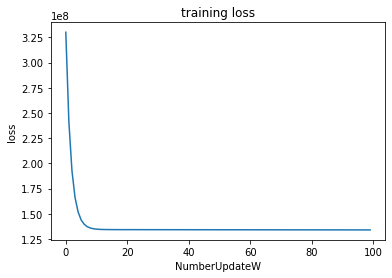

In [63]:
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")
plt.show()

# Use age

In [64]:
train= data_train.select("age","charges")
test= data_test.select("age","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
loss=sc.parallelize([])
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 38.762834787368774
[[334.52258088]
 [ 10.87144731]]


In [65]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 6032.277903169033),
 (2200.83085, 6032.277903169033),
 (7323.734819, 6032.277903169033),
 (2205.9808, 6032.277903169033),
 (1629.8335, 6032.277903169033),
 (14133.03775, 6032.277903169033),
 (1704.70015, 6032.277903169033),
 (1711.0268, 6032.277903169033),
 (1708.0014, 6032.277903169033),
 (3481.868, 6032.277903169033),
 (33732.6867, 6032.277903169033),
 (1137.4697, 6032.277903169033),
 (1727.54, 6032.277903169033),
 (1146.7966, 6032.277903169033),
 (13844.506, 6366.800484050092),
 (17081.08, 6366.800484050092),
 (1744.465, 6366.800484050092),
 (2719.27975, 6366.800484050092),
 (1242.26, 6366.800484050092),
 (1625.43375, 6366.800484050092),
 (1628.4709, 6366.800484050092),
 (1632.56445, 6366.800484050092),
 (32548.3405, 6366.800484050092),
 (1261.442, 6366.800484050092),
 (17085.2676, 6701.32306493115),
 (2459.7201, 6701.32306493115),
 (1877.9294, 6701.32306493115),
 (1880.487, 6701.32306493115),
 (1980.07, 6701.32306493115),
 (1391.5287, 6701.32306493115),
 (17942.106, 70

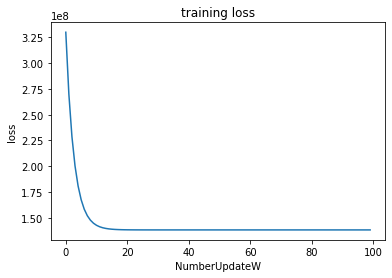

In [66]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

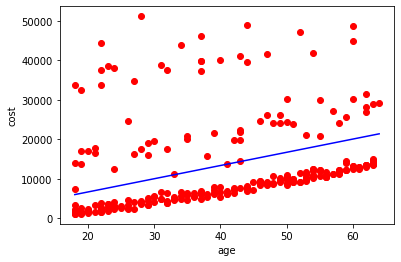

In [67]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("age")
plt.ylabel("cost")
plt.show()

# Use sex

In [68]:
train= data_train.select("sex_index","charges")
test= data_test.select("sex_index","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 32.74695348739624
[[ 61.55529235]
 [132.92180012]]


In [69]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 194.47709246493986),
 (2200.83085, 194.47709246493986),
 (7323.734819, 194.47709246493986),
 (2205.9808, 194.47709246493986),
 (1629.8335, 194.47709246493986),
 (14133.03775, 194.47709246493986),
 (1704.70015, 132.92180011911364),
 (1711.0268, 132.92180011911364),
 (1708.0014, 132.92180011911364),
 (3481.868, 132.92180011911364),
 (33732.6867, 132.92180011911364),
 (1137.4697, 132.92180011911364),
 (1727.54, 132.92180011911364),
 (1146.7966, 132.92180011911364),
 (13844.506, 194.47709246493986),
 (17081.08, 194.47709246493986),
 (1744.465, 194.47709246493986),
 (2719.27975, 194.47709246493986),
 (1242.26, 132.92180011911364),
 (1625.43375, 132.92180011911364),
 (1628.4709, 132.92180011911364),
 (1632.56445, 132.92180011911364),
 (32548.3405, 132.92180011911364),
 (1261.442, 132.92180011911364),
 (17085.2676, 194.47709246493986),
 (2459.7201, 194.47709246493986),
 (1877.9294, 194.47709246493986),
 (1880.487, 194.47709246493986),
 (1980.07, 132.92180011911364),
 (1391.5287, 

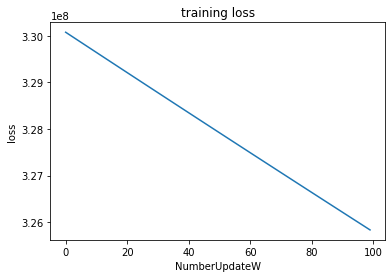

In [70]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

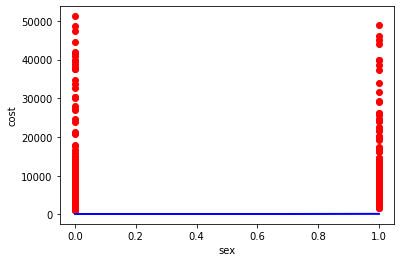

In [71]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("sex")
plt.ylabel("cost")
plt.show()

# Use BMI

In [72]:
train= data_train.select("bmi","charges")
test= data_test.select("bmi","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 35.39224338531494
[[435.90043853]
 [ 13.81517937]]


In [73]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 10946.198177661281),
 (2200.83085, 12312.746052447335),
 (7323.734819, 12726.851469049168),
 (2205.9808, 13927.75717719449),
 (1629.8335, 16076.746339138745),
 (14133.03775, 16700.08396623414),
 (1704.70015, 10076.57680279743),
 (1711.0268, 10179.013405851569),
 (1708.0014, 11111.840344302016),
 (3481.868, 13265.188510631553),
 (33732.6867, 13844.936093874121),
 (1137.4697, 15021.867277900386),
 (1727.54, 15357.510615567138),
 (1146.7966, 17946.759220424923),
 (13844.506, 9472.854695435808),
 (17081.08, 12349.797589722237),
 (1744.465, 13003.648247514606),
 (2719.27975, 13886.346635534304),
 (1242.26, 8862.594081496263),
 (1625.43375, 8917.081636312294),
 (1628.4709, 9869.524094496512),
 (1632.56445, 11153.2508859622),
 (32548.3405, 13199.803444852316),
 (1261.442, 14878.020133186066),
 (17085.2676, 11713.382949470995),
 (2459.7201, 13348.00959395192),
 (1877.9294, 13727.242975471496),
 (1880.487, 14529.299782363467),
 (1980.07, 14398.529650804994),
 (1391.5287, 14542.3767

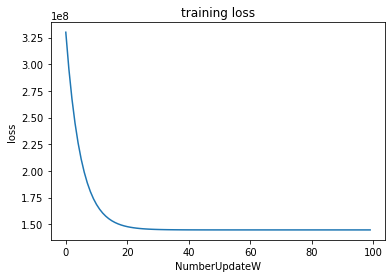

In [74]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

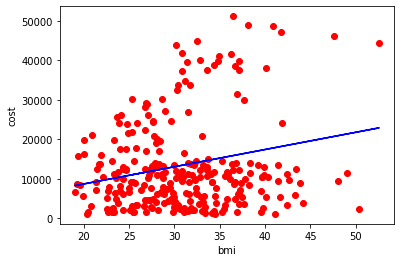

In [75]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("bmi")
plt.ylabel("cost")
plt.show()

# Use children

In [76]:
train= data_train.select("children","charges")
test= data_test.select("children","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 42.378323554992676
[[156.75610823]
 [132.20777075]]


In [77]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 132.20777075190867),
 (2200.83085, 132.20777075190867),
 (7323.734819, 132.20777075190867),
 (2205.9808, 132.20777075190867),
 (1629.8335, 132.20777075190867),
 (14133.03775, 132.20777075190867),
 (1704.70015, 132.20777075190867),
 (1711.0268, 288.9638789783702),
 (1708.0014, 132.20777075190867),
 (3481.868, 602.4760954312932),
 (33732.6867, 132.20777075190867),
 (1137.4697, 132.20777075190867),
 (1727.54, 288.9638789783702),
 (1146.7966, 132.20777075190867),
 (13844.506, 132.20777075190867),
 (17081.08, 132.20777075190867),
 (1744.465, 132.20777075190867),
 (2719.27975, 288.9638789783702),
 (1242.26, 132.20777075190867),
 (1625.43375, 132.20777075190867),
 (1628.4709, 132.20777075190867),
 (1632.56445, 132.20777075190867),
 (32548.3405, 132.20777075190867),
 (1261.442, 132.20777075190867),
 (17085.2676, 288.9638789783702),
 (2459.7201, 132.20777075190867),
 (1877.9294, 132.20777075190867),
 (1880.487, 132.20777075190867),
 (1980.07, 288.9638789783702),
 (1391.5287, 132.20

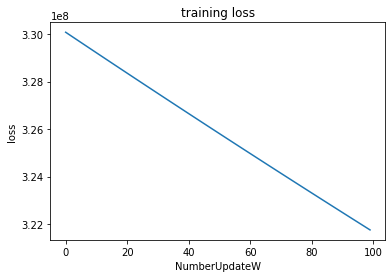

In [78]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

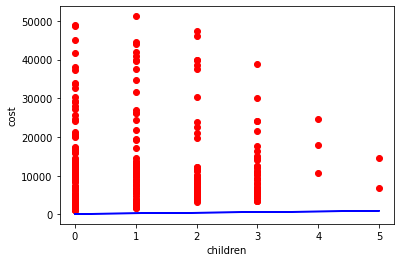

In [79]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("children")
plt.ylabel("cost")
plt.show()

# Use smoker

In [80]:
train= data_train.select("smoker_index","charges")
test= data_test.select("smoker_index","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 32.50568151473999
[[ 66.77870869]
 [133.00507853]]


In [81]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 133.0050785298713),
 (2200.83085, 133.0050785298713),
 (7323.734819, 133.0050785298713),
 (2205.9808, 133.0050785298713),
 (1629.8335, 133.0050785298713),
 (14133.03775, 133.0050785298713),
 (1704.70015, 133.0050785298713),
 (1711.0268, 133.0050785298713),
 (1708.0014, 133.0050785298713),
 (3481.868, 133.0050785298713),
 (33732.6867, 199.78378722309958),
 (1137.4697, 133.0050785298713),
 (1727.54, 133.0050785298713),
 (1146.7966, 133.0050785298713),
 (13844.506, 199.78378722309958),
 (17081.08, 199.78378722309958),
 (1744.465, 133.0050785298713),
 (2719.27975, 133.0050785298713),
 (1242.26, 133.0050785298713),
 (1625.43375, 133.0050785298713),
 (1628.4709, 133.0050785298713),
 (1632.56445, 133.0050785298713),
 (32548.3405, 199.78378722309958),
 (1261.442, 133.0050785298713),
 (17085.2676, 199.78378722309958),
 (2459.7201, 133.0050785298713),
 (1877.9294, 133.0050785298713),
 (1880.487, 133.0050785298713),
 (1980.07, 133.0050785298713),
 (1391.5287, 133.0050785298713),
 (17

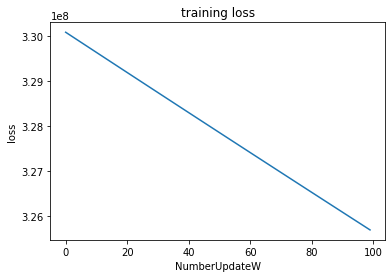

In [82]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

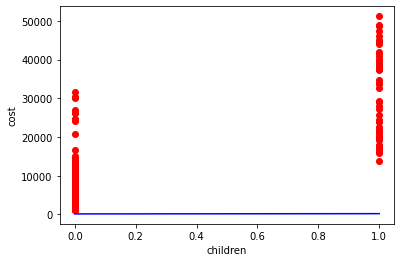

In [83]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("children")
plt.ylabel("cost")
plt.show()

# Use region

In [84]:
train= data_train.select("region_index","charges")
test= data_test.select("region_index","charges")
rdd_train=train.rdd
rdd_test=test.rdd
weight = []
lr_delta=[]
create_weight()
print(weight)
start=time.time()
train_weight()
end=time.time()
difference=end-start
print("Time taken in seconds:",difference)
print(weight)

[[0.]
 [0.]]
Time taken in seconds: 39.103800773620605
[[185.51786814]
 [131.73400315]]


In [85]:

rdd_predict=rdd_test.map(lambda x:predict(x,weight))
print("[True_Label,Predict]")
rdd_predict.collect()


[True_Label,Predict]


[(2196.4732, 688.2876075738045),
 (2200.83085, 688.2876075738045),
 (7323.734819, 688.2876075738045),
 (2205.9808, 688.2876075738045),
 (1629.8335, 131.7340031452082),
 (14133.03775, 131.7340031452082),
 (1704.70015, 688.2876075738045),
 (1711.0268, 131.7340031452082),
 (1708.0014, 688.2876075738045),
 (3481.868, 688.2876075738045),
 (33732.6867, 688.2876075738045),
 (1137.4697, 131.7340031452082),
 (1727.54, 131.7340031452082),
 (1146.7966, 131.7340031452082),
 (13844.506, 502.769739430939),
 (17081.08, 502.769739430939),
 (1744.465, 502.769739430939),
 (2719.27975, 317.25187128807363),
 (1242.26, 502.769739430939),
 (1625.43375, 317.25187128807363),
 (1628.4709, 317.25187128807363),
 (1632.56445, 317.25187128807363),
 (32548.3405, 131.7340031452082),
 (1261.442, 502.769739430939),
 (17085.2676, 131.7340031452082),
 (2459.7201, 688.2876075738045),
 (1877.9294, 131.7340031452082),
 (1880.487, 502.769739430939),
 (1980.07, 502.769739430939),
 (1391.5287, 131.7340031452082),
 (17942.106,

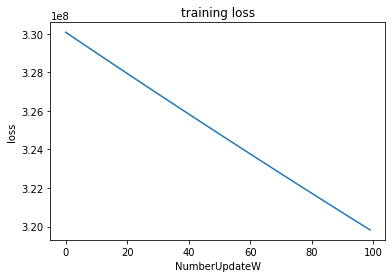

In [86]:
draw_loss=loss.map(lambda x: np.float(x[1])).collect()
plt.plot(range(NumberUpdateW), draw_loss)
plt.title("training loss")
plt.xlabel("NumberUpdateW")
plt.ylabel("loss")

plt.show()

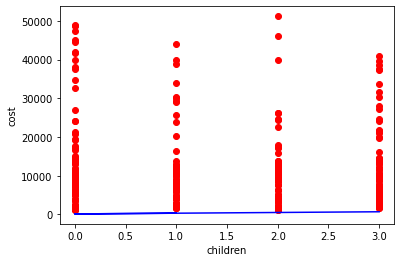

In [87]:
draw_x_test=rdd_test.map(lambda x:x[0]).collect()
draw_y_test=rdd_test.map(lambda x:x[1]).collect()
draw_y_predict=rdd_predict.map(lambda x:x[1]).collect()

plt.scatter(draw_x_test,draw_y_test,color="red")
plt.plot(draw_x_test, draw_y_predict,color="blue")

plt.xlabel("children")
plt.ylabel("cost")
plt.show()